In [22]:
import ambulance_game as abg
import numpy as np
import matplotlib.pyplot as plt
import random
import ciw
import collections
import scipy.optimize
import itertools


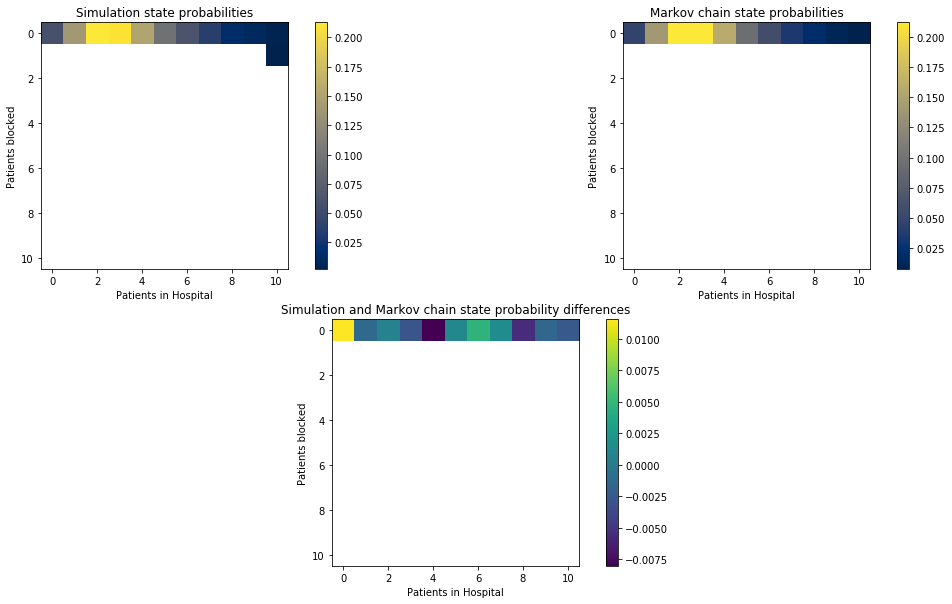

In [23]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_2=0.2,
    lambda_1=0.1,
    mu=0.1,
    num_of_servers=5,
    threshold=11,
    system_capacity=10,
    buffer_capacity=10,
    runtime=10000,
    num_of_trials=1,
)


In [47]:
def build_states(threshold, system_capacity, buffer_capacity):
    if threshold > system_capacity:
        states_1 = [(0, v) for v in range(0, system_capacity + 1)]
        states_2 = [(1, system_capacity)]
        all_states = states_1 + states_2
        return all_states

    states_1 = [(0, v) for v in range(0, threshold)]
    states_2 = [
        (u, v)
        for v in range(threshold, system_capacity + 1)
        for u in range(buffer_capacity + 1)
    ]
    all_states = states_1 + states_2
    return all_states


In [25]:
def get_transition_matrix_entry(
    origin, destination, threshold, lambda_2, lambda_1, Lambda, mu, num_of_servers
):
    row_diff = origin[0] - destination[0]
    column_diff = origin[1] - destination[1]

    if row_diff == 0 and column_diff == -1:
        if origin[1] < threshold:
            return Lambda
        return lambda_1
    elif row_diff == -1 and column_diff == 0:
        return lambda_2
    elif row_diff == 0 and column_diff == 1:
        if origin[1] <= num_of_servers:
            return origin[1] * mu
        else:
            return num_of_servers * mu
    elif row_diff == 1 and column_diff == 0 and origin[1] == threshold:
        return threshold * mu
    else:
        return 0


In [91]:
def get_transition_matrix(
    lambda_2, lambda_1, mu, num_of_servers, threshold, system_capacity, buffer_capacity
):
    all_states = build_states(threshold, system_capacity, buffer_capacity)

    threshold = system_capacity
    buffer_capacity = 1

    size = len(all_states)
    Q = np.zeros((size, size))

    for (i, origin_state), (j, destination_state) in itertools.product(
        enumerate(all_states), repeat=2
    ):
        Q[i, j] = get_transition_matrix_entry(
            origin=origin_state,
            destination=destination_state,
            threshold=threshold,
            lambda_2=lambda_2,
            lambda_1=lambda_1,
            Lambda=lambda_2 + lambda_1,
            mu=mu,
            num_of_servers=num_of_servers,
        )
    sum_of_rates = np.sum(Q, axis=1)
    np.fill_diagonal(Q, -sum_of_rates)
    return Q


In [92]:
def is_steady_state(state, Q):
    return np.allclose(np.dot(state, Q), 0)


In [93]:
def augment_Q(Q):
    dimension = Q.shape[0]
    M = np.vstack((Q.transpose()[:-1], np.ones(dimension)))
    b = np.vstack((np.zeros((dimension - 1, 1)), [1]))
    return M, b


def get_steady_state_algebraically(Q, algebraic_function=np.linalg.solve):
    M, b = augment_Q(Q)
    if algebraic_function == np.linalg.solve:
        state = algebraic_function(M, b).transpose()[0]
    elif algebraic_function == np.linalg.lstsq:
        state = algebraic_function(M, b, rcond=None)[0][:, 0]
    return state


In [94]:
def get_markov_state_probabilities(
    pi, all_states, output=np.ndarray, system_capacity=None, buffer_capacity=None
):
    if output == dict:
        states_probabilities_dictionary = {}
        for i in range(len(all_states)):
            states_probabilities_dictionary[all_states[i]] = pi[i]
        return states_probabilities_dictionary
    elif output == np.ndarray:
        if buffer_capacity == None:
            buffer_capacity = max([state[0] for state in all_states])
        if system_capacity == None:
            system_capacity = max([state[1] for state in all_states])
        states_probabilities_array = np.full(
            (buffer_capacity + 1, system_capacity + 1), np.NaN
        )
        for index in range(len(all_states)):
            states_probabilities_array[all_states[index]] = pi[index]
        return states_probabilities_array


In [95]:
lambda_2 = 0.2
lambda_1 = 0.1
mu = 0.1
num_of_servers = 5
threshold = 11
system_capacity = 10
buffer_capacity = 10


In [96]:
states = build_states(threshold, system_capacity, buffer_capacity)


In [97]:
states


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (1, 10)]

In [98]:
transition_matrix = get_transition_matrix(
    lambda_2, lambda_1, mu, num_of_servers, threshold, system_capacity, buffer_capacity
)
transition_matrix


array([[-0.3,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 0.1, -0.4,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 0. ,  0.2, -0.5,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 0. ,  0. ,  0.3, -0.6,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 0. ,  0. ,  0. ,  0.4, -0.7,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.5, -0.8,  0.3,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.5, -0.8,  0.3,  0. ,  0. ,  0. ,
         0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5, -0.8,  0.3,  0. ,  0. ,
         0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5, -0.8,  0.3,  0. ,
         0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5, -0.8,  0.3,
         0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5, -0.7,
         0.2],
       [ 0. ,  0. ,  

In [99]:
pi = get_steady_state_algebraically(transition_matrix)


In [100]:
pi


array([0.04709695, 0.14129085, 0.21193628, 0.21193628, 0.15895221,
       0.09537133, 0.0572228 , 0.03433368, 0.02060021, 0.01236012,
       0.00741607, 0.00148321])

In [101]:
pi_array = get_markov_state_probabilities(pi, states)
pi_array


array([[0.04709695, 0.14129085, 0.21193628, 0.21193628, 0.15895221,
        0.09537133, 0.0572228 , 0.03433368, 0.02060021, 0.01236012,
        0.00741607],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
        0.00148321]])